In [2]:
import os
import cv2
import json
import random
import orjson
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict, Counter
from matplotlib import pyplot as plt

from utils import seg_to_mask, PoissonDiskSampler

In [2]:
DATASET_PATH = '/home/ai2lab/work/datasets'

In [3]:
data = json.load(open(f"{DATASET_PATH}/PartImagenet/annotations/train/train.json"))

In [4]:
cat_dict = {c['id']: c for c in data['categories']}
ann_dict = defaultdict(list)
for ann in data['annotations']:
    ann_dict[ann['image_id']].append(ann)

In [5]:
sel_data = []
for img in tqdm(data['images']):
    img_id = img['id']
    img_area = img['width'] * img['height']
    
    img_filename = img['file_name']
    image_path = f'PartImagenet/images/train/{img_filename}'
    
    anns = ann_dict[img_id]
    
    if len(anns) == 0:
        continue
    
    ann_by_class = defaultdict(list)
    for ann in anns:
        ann_area = ann['bbox'][2] * ann['bbox'][3]
        ann['area_ratio'] = ann_area / img_area
        cat_id = ann['category_id']
        
        ann_by_class[cat_id].append(ann)
        
    for cat_id, objects in ann_by_class.items():
        if len(objects) > 5:
            continue
        if not all(bbox['area_ratio'] > 0.02 for bbox in objects):
            continue
        
        sel_data.append({
            'image_path': image_path,
            'img_width': img['width'],
            'img_height': img['height'],
            'obj_name': cat_dict[cat_id]['name'],
            'objects': objects,
        })

  0%|          | 0/20481 [00:00<?, ?it/s]

In [6]:
poisson_disk_sampler = PoissonDiskSampler(num_samples=100, radius=0.1)

In [7]:
num_errors = 0
all_ref_data = []
for d in tqdm(sel_data):
    try:
        image_path = d['image_path']
        img_w, img_h = d['img_width'], d['img_height']
        phrases = [d['obj_name']]
        
        bboxes = []
        points_and_labels = []
        for obj in d['objects']:
            bbox = obj['bbox']
            bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
            
            gt_mask = seg_to_mask(obj['segmentation'], img_h, img_w)
            
            scaled_bbox = [bbox[0]/img_w*1000, bbox[1]/img_h*1000, bbox[2]/img_w*1000, bbox[3]/img_h*1000]
            scaled_bbox = [int(round(x)) for x in scaled_bbox]
            scaled_bbox = [
                max(0, scaled_bbox[0]),
                max(0, scaled_bbox[1]),
                min(999, scaled_bbox[2]),
                min(999, scaled_bbox[3]),
            ]
            
            rand_points = poisson_disk_sampler.sample(bbox)
            rand_points = [(int(x), int(y)) for x, y in rand_points]
            on_masks = gt_mask[np.array(rand_points)[:, 1], np.array(rand_points)[:, 0]]
            
            scaled_rand_points = [(x/img_w*1000, y/img_h*1000) for x, y in rand_points]
            scaled_rand_points_on_mask = [(int(x), int(y), int(on_mask)) for (x, y), on_mask in zip(scaled_rand_points, on_masks)]
            
            bboxes.append(scaled_bbox)
            points_and_labels.append(scaled_rand_points_on_mask)
            
        assert len(bboxes) == len(points_and_labels)
        
        all_ref_data.append({
            'image_path': image_path,
            'phrases': phrases,
            'bboxes': bboxes,
            'points_and_labels': points_and_labels,
        })
    except Exception as e:
        # raise e
        num_errors += 1
        if num_errors % 10 == 0:
            print(f'num_errors={num_errors}')
        continue

  0%|          | 0/41766 [00:00<?, ?it/s]

num_errors=10
num_errors=20
num_errors=30
num_errors=40
num_errors=50
num_errors=60
num_errors=70
num_errors=80
num_errors=90
num_errors=100
num_errors=110
num_errors=120
num_errors=130
num_errors=140
num_errors=150
num_errors=160
num_errors=170
num_errors=180
num_errors=190
num_errors=200
num_errors=210
num_errors=220
num_errors=230
num_errors=240
num_errors=250
num_errors=260
num_errors=270
num_errors=280
num_errors=290
num_errors=300
num_errors=310
num_errors=320
num_errors=330
num_errors=340
num_errors=350
num_errors=360
num_errors=370
num_errors=380
num_errors=390
num_errors=400
num_errors=410
num_errors=420
num_errors=430
num_errors=440
num_errors=450
num_errors=460
num_errors=470
num_errors=480
num_errors=490
num_errors=500
num_errors=510
num_errors=520
num_errors=530
num_errors=540


In [8]:
with open('processed_data_v2/partimagenet_ref_data.json', 'w') as f:
    f.write(orjson.dumps(all_ref_data).decode())

In [3]:
with open('processed_data_v2/partimagenet_ref_data.json', 'r') as f:
    all_ref_data = orjson.loads(f.read())

In [6]:
# num unique images
len(set(d['image_path'] for d in all_ref_data))

19422

In [4]:
len(all_ref_data)

41218

['Snake Body']


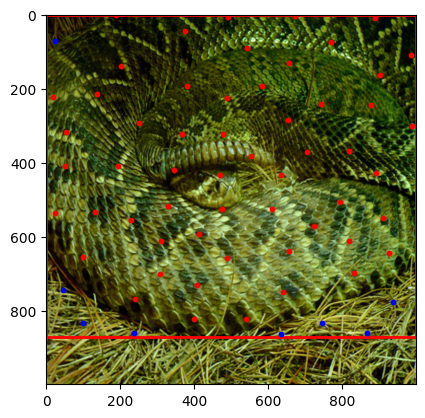

['Quadruped Head']


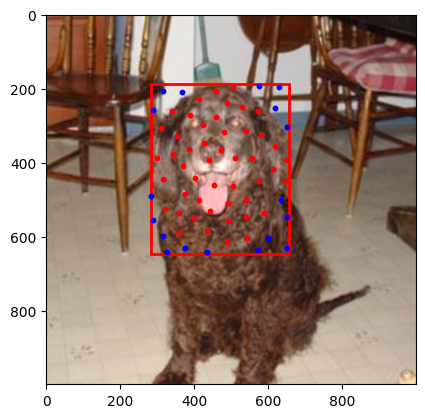

['Bird Tail']


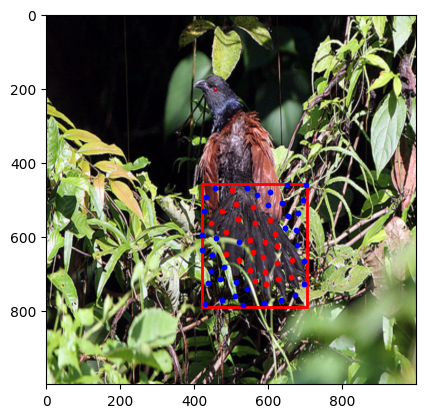

['Fish Body']


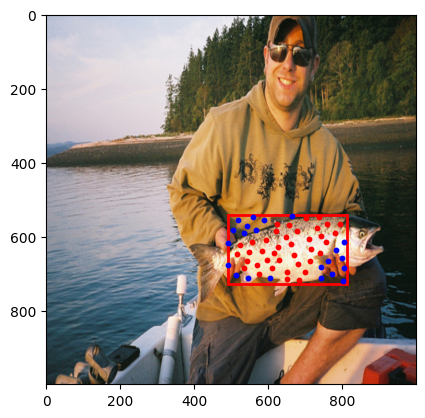

['Aeroplane Tail']


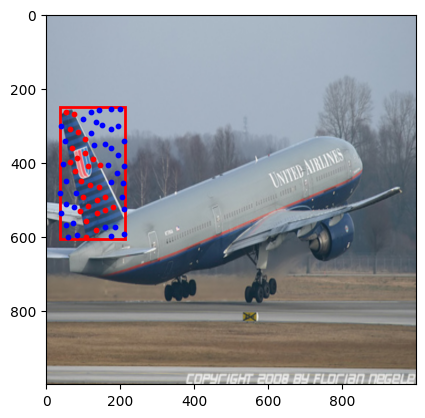

In [9]:
for d in random.sample(all_ref_data, 5):
    image_path = os.path.join(DATASET_PATH, d['image_path'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1000, 1000))
    bboxes = d['bboxes']
    points_and_labels = d['points_and_labels']

    print(d['phrases'])
    plt.imshow(image)
    for bbox in bboxes:
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))

    for points_and_labels_i in points_and_labels:
        for x, y, on_mask in points_and_labels_i:
            plt.scatter(x, y, c='red' if on_mask else 'blue', s=10)

    plt.show()